# Challenge 1

In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
def is_running_on_kaggle():
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ and os.environ["KAGGLE_KERNEL_RUN_TYPE"] == "Interactive"
DATA_PATH = '/kaggle/input/aerial-cactus/' if is_running_on_kaggle() else 'data/'
print('Running on Kaggle' if is_running_on_kaggle() else 'Running locally')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Running locally


Import required libraries

In [20]:
import torch
import torchvision
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm

In [21]:
# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


Define some useful constants.

In [22]:
ANNOTATIONS_FILE = DATA_PATH + 'train.csv'
IMG_DIR = DATA_PATH + 'train/train/'
CHECKPOINT_DIR = '/kaggle/working/checkpoints' if is_running_on_kaggle() else 'checkpoints/'
FIGURES_DIR = '/kaggle/working/figures' if is_running_on_kaggle() else 'figures/'

SEED = 42
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
TRAIN_SPLIT = 0.8
EPOCHS = 100 if is_running_on_kaggle() else 100

Set the manual seed.

In [23]:
torch.manual_seed(42)

Extend **Dataset** class for the **DatasetLoader** (define a mapping for images and labels).

In [24]:
from torchvision.io import read_image

class CactusDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, transform_minority=None, target_transform=None, equalize=False):
        self.equalize = equalize
        if self.equalize:
            self.img_labels = self.equalize_dataset(annotations_file)
        else:
            self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.transform_minority = transform_minority

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            if label == 1:
                image = self.transform(image)
            else:
                image = self.transform_minority(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    def equalize_dataset(self, file):
        df = pd.read_csv(file)
        filtered_rows = df[df['has_cactus']==0]
        df = pd.concat([df, filtered_rows], ignore_index=True)
        df = pd.concat([df, filtered_rows], ignore_index=True)
        return df

TODO: Try to preprocess like in ImProc

Instanciate a **Dataset** object on the training (+validation) data.

In [25]:
# Imagenet mean and std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
mean = [0.5035902857780457, 0.451941579580307, 0.4681771695613861]
std = [0.15118408203125, 0.1397838294506073, 0.15320344269275665]

In [26]:
import torchvision.transforms as transforms

# Transformation for the image data
transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=mean, std=std),
])
transform_minority = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=np.random.uniform(0,30)),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=mean, std=std),
    
])

In [27]:
# Create the dataset object
trainval_data = CactusDataset(ANNOTATIONS_FILE, IMG_DIR, transform=transform, transform_minority=transform_minority, equalize=True)

In [28]:
# Print the shape of the first image in the dataset
print(trainval_data[0][0].shape)

torch.Size([3, 32, 32])


Split the dataset into train + validation

In [29]:
from torch.utils.data import random_split

# Define the sizes of training and validation sets
train_size = int(TRAIN_SPLIT * len(trainval_data))
val_size = len(trainval_data) - train_size

# Split the dataset into training and validation sets
train_data, val_data = random_split(trainval_data, [train_size, val_size])

# Print the sizes of the training and validation sets
print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))

Training set size: 20982
Validation set size: 5246


Let's define our first model.\
We are going to use the ResNet18 pretrained model and then we are going to add 1 linear FC output layer. The output will be a real value that we will feed into a Sigmoid function to squash it into the $[0, 1]$ interval, and we will do the classification by comparing the output of the Sigmoid with the $0.5$ treshold.\
Since we don't want to adjust ResNet18 weights, we are going to set the **requires_grad** property to **False** for each of its parameters.

In [30]:
from torchvision.models import resnet18, ResNet18_Weights

class ResnetClassificator(nn.Module):
    def __init__(self, fc_size=None):
        super(ResnetClassificator, self).__init__()
        
        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        for param in resnet.parameters():
            param.requires_grad = False
        
        self.resnet = resnet
        self.fc_size = 1 if fc_size is None or fc_size < 2 else fc_size
        if self.fc_size < 2:
            self.fc1 = nn.Linear(resnet.fc.out_features, 1)
        else:
            self.fc1 = nn.Linear(resnet.fc.out_features, fc_size)
            self.fc2 = nn.Linear(fc_size, 1)

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc1(x)
        if self.fc_size != 1:
            x = self.fc2(x)
        return x

At this point, let's train our model.

In [31]:
# Utility function for saving epochs checkpoints
def save_checkpoint(model, optimizer, loss, dir, desc):
    checkpoint_dir = os.path.join(CHECKPOINT_DIR, dir)
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{desc}.pt')
    torch.save({
        'desc': desc,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)

# Utility function for loading epochs checkpoints
def load_checkpoint(model, optimizer, dir, desc):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, dir, f'checkpoint_{desc}.pt')
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    return model, optimizer, loss

In [32]:
# Training loop (1 epoch)
def train_model(train_dataloader, model, criterion, optimizer, checkpoint=False, desc='Training', dir_checkpoint=None):
    avg_train_loss = 0
    train_bar = tqdm(train_dataloader, desc=desc, leave=False)
    
    model.train()
    for X, y in train_bar:
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X.float())
        y = y.reshape(-1, 1).float()
        loss = criterion(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the average loss
        avg_train_loss += loss.item() * len(y)

        # Update the loading bar
        train_bar.set_postfix({'loss': loss.item()})
        
    avg_train_loss = avg_train_loss / len(train_dataloader.dataset)
    train_bar.set_postfix({'loss': avg_train_loss})
    train_bar.close()

    if checkpoint:
        save_checkpoint(model, optimizer, avg_train_loss, dir_checkpoint, desc)

    return avg_train_loss

In [33]:
# Compute validation loss and error rate
def evaluate(val_dataloader, model, criterion, desc='Validation'):
    avg_val_loss = 0
    errors = []
    val_bar = tqdm(val_dataloader, desc=desc, leave=False)

    model.eval()
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    with torch.no_grad():
        for X, y in val_bar:
            X = X.to(device)
            y = y.to(device)

            # Compute prediction and loss
            pred = model(X.float())
            y = y.reshape(-1, 1).float()
            loss = criterion(pred, y)

            # Save errors for error rate
            pred = nn.Sigmoid()(pred) > 0.5

            tp += torch.bitwise_and(y == 1, pred == 1).sum().item()
            tn += torch.bitwise_and(y == 0, pred == 0).sum().item()
            fp += torch.bitwise_and(y == 0, pred == 1).sum().item()
            fn += torch.bitwise_and(y == 1, pred == 0).sum().item()

            errors += pred != y

            # Update the average loss
            avg_val_loss += loss.item() * len(y)

            # Update the loading bar
            val_bar.set_postfix({'loss': loss.item()})
    
    avg_val_loss = avg_val_loss / len(val_dataloader.dataset)
    val_bar.set_postfix({'loss': avg_val_loss})
    val_bar.close()
    return avg_val_loss, errors, [[tp, fp], [fn, tn]]

In [34]:
# Early stopping
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [35]:
def f1_score(confusion_matrix):
    tp, fp = confusion_matrix[0]
    fn, _ = confusion_matrix[1]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return 2 * (precision * recall) / (precision + recall)

In [36]:
class CustomConvNet(torch.nn.Module):
    def __init__(self, fc_size, dropout):
        super(CustomConvNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128, fc_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(fc_size, 1)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

>>>>>>>>     FC Size: 6 - Dropout: 0.1     <<<<<<<<


TrainingEpoch01:   0%|          | 0/328 [00:00<?, ?it/s]

Epoch 1/100	 Train Loss: 0.1816 - Val Loss: 0.0579 - Error Rate: 0.0210 - F1 Score: 0.9792 - (FPR: 0.0200 - FNR: 0.0219)


Epoch 2/100	 Train Loss: 0.0834 - Val Loss: 0.0708 - Error Rate: 0.0265 - F1 Score: 0.9731 - (FPR: 0.0032 - FNR: 0.0482)


Epoch 3/100	 Train Loss: 0.0604 - Val Loss: 0.0352 - Error Rate: 0.0130 - F1 Score: 0.9872 - (FPR: 0.0158 - FNR: 0.0101)


Epoch 4/100	 Train Loss: 0.0477 - Val Loss: 0.0316 - Error Rate: 0.0120 - F1 Score: 0.9882 - (FPR: 0.0190 - FNR: 0.0047)


Epoch 5/100	 Train Loss: 0.0401 - Val Loss: 0.0210 - Error Rate: 0.0067 - F1 Score: 0.9934 - (FPR: 0.0057 - FNR: 0.0077)


Epoch 6/100	 Train Loss: 0.0358 - Val Loss: 0.0167 - Error Rate: 0.0051 - F1 Score: 0.9949 - (FPR: 0.0027 - FNR: 0.0077)


Epoch 7/100	 Train Loss: 0.0283 - Val Loss: 0.0140 - Error Rate: 0.0042 - F1 Score: 0.9958 - (FPR: 0.0015 - FNR: 0.0069)


Epoch 8/100	 Train Loss: 0.0214 - Val Loss: 0.0152 - Error Rate: 0.0038 - F1 Score: 0.9962 - (FPR: 0.0015 - FNR: 0.0061)


Epoch 9/100	 Train Loss: 0.0188 - Val Loss: 0.0249 - Error Rate: 0.0084 - F1 Score: 0.9917 - (FPR: 0.0142 - FNR: 0.0023)


Epoch 10/100	 Train Loss: 0.0156 - Val Loss: 0.0136 - Error Rate: 0.0042 - F1 Score: 0.9958 - (FPR: 0.0038 - FNR: 0.0046)


Epoch 11/100	 Train Loss: 0.0119 - Val Loss: 0.0267 - Error Rate: 0.0065 - F1 Score: 0.9935 - (FPR: 0.0004 - FNR: 0.0126)


Epoch 12/100	 Train Loss: 0.0145 - Val Loss: 0.0145 - Error Rate: 0.0051 - F1 Score: 0.9949 - (FPR: 0.0071 - FNR: 0.0031)


Epoch 13/100	 Train Loss: 0.0115 - Val Loss: 0.0238 - Error Rate: 0.0071 - F1 Score: 0.9930 - (FPR: 0.0000 - FNR: 0.0140)


Epoch 14/100	 Train Loss: 0.0085 - Val Loss: 0.0230 - Error Rate: 0.0071 - F1 Score: 0.9930 - (FPR: 0.0008 - FNR: 0.0133)


Epoch 15/100	 Train Loss: 0.0148 - Val Loss: 0.0127 - Error Rate: 0.0034 - F1 Score: 0.9966 - (FPR: 0.0049 - FNR: 0.0019)


Epoch 16/100	 Train Loss: 0.0081 - Val Loss: 0.0169 - Error Rate: 0.0051 - F1 Score: 0.9949 - (FPR: 0.0015 - FNR: 0.0088)


Epoch 17/100	 Train Loss: 0.0085 - Val Loss: 0.0167 - Error Rate: 0.0038 - F1 Score: 0.9962 - (FPR: 0.0011 - FNR: 0.0065)


Epoch 18/100	 Train Loss: 0.0075 - Val Loss: 0.0340 - Error Rate: 0.0099 - F1 Score: 0.9901 - (FPR: 0.0000 - FNR: 0.0196)


Epoch 19/100	 Train Loss: 0.0136 - Val Loss: 0.0131 - Error Rate: 0.0046 - F1 Score: 0.9955 - (FPR: 0.0011 - FNR: 0.0080)


Epoch 20/100	 Train Loss: 0.0073 - Val Loss: 0.0074 - Error Rate: 0.0025 - F1 Score: 0.9975 - (FPR: 0.0011 - FNR: 0.0038)


Epoch 21/100	 Train Loss: 0.0046 - Val Loss: 0.0104 - Error Rate: 0.0021 - F1 Score: 0.9979 - (FPR: 0.0008 - FNR: 0.0035)


Epoch 22/100	 Train Loss: 0.0079 - Val Loss: 0.0112 - Error Rate: 0.0030 - F1 Score: 0.9970 - (FPR: 0.0011 - FNR: 0.0050)


Epoch 23/100	 Train Loss: 0.0067 - Val Loss: 0.0098 - Error Rate: 0.0025 - F1 Score: 0.9975 - (FPR: 0.0015 - FNR: 0.0035)


Epoch 24/100	 Train Loss: 0.0082 - Val Loss: 0.0232 - Error Rate: 0.0050 - F1 Score: 0.9951 - (FPR: 0.0004 - FNR: 0.0095)


Epoch 25/100	 Train Loss: 0.0053 - Val Loss: 0.0089 - Error Rate: 0.0021 - F1 Score: 0.9979 - (FPR: 0.0008 - FNR: 0.0035)


Epoch 26/100	 Train Loss: 0.0116 - Val Loss: 0.0152 - Error Rate: 0.0034 - F1 Score: 0.9966 - (FPR: 0.0015 - FNR: 0.0054)


Epoch 27/100	 Train Loss: 0.0058 - Val Loss: 0.0113 - Error Rate: 0.0032 - F1 Score: 0.9968 - (FPR: 0.0019 - FNR: 0.0046)


Epoch 28/100	 Train Loss: 0.0062 - Val Loss: 0.0217 - Error Rate: 0.0051 - F1 Score: 0.9949 - (FPR: 0.0000 - FNR: 0.0103)


Epoch 29/100	 Train Loss: 0.0073 - Val Loss: 0.0151 - Error Rate: 0.0036 - F1 Score: 0.9964 - (FPR: 0.0008 - FNR: 0.0065)


Epoch 30/100	 Train Loss: 0.0063 - Val Loss: 0.0495 - Error Rate: 0.0189 - F1 Score: 0.9816 - (FPR: 0.0337 - FNR: 0.0028)
Early stopping on epoch 30


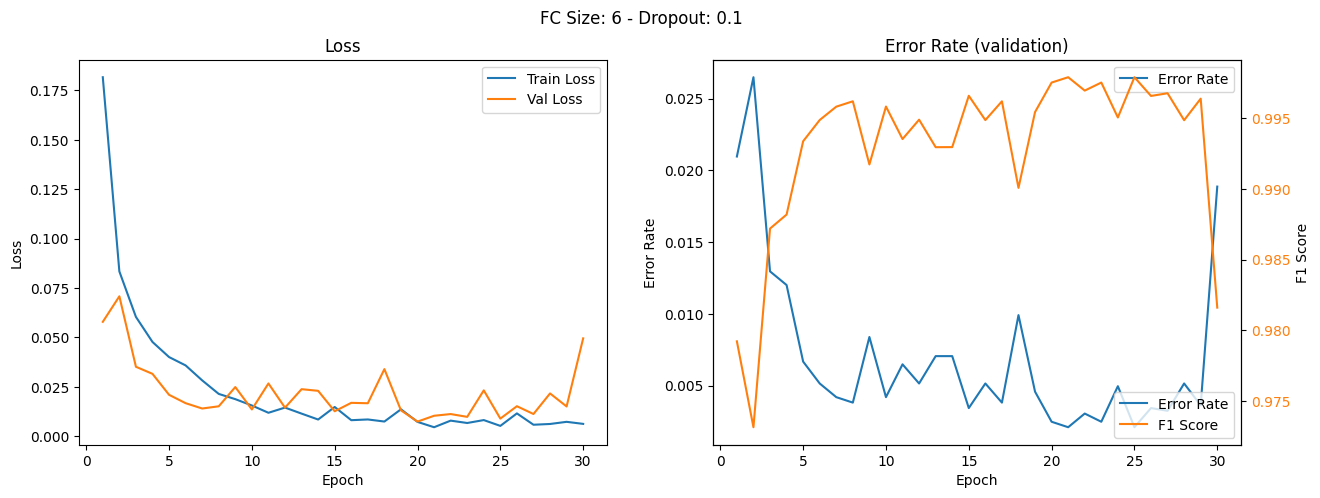

>>>>>>>>     FC Size: 6 - Dropout: 0.3     <<<<<<<<


Epoch 1/100	 Train Loss: 0.1900 - Val Loss: 0.0601 - Error Rate: 0.0227 - F1 Score: 0.9772 - (FPR: 0.0070 - FNR: 0.0377)


Epoch 2/100	 Train Loss: 0.1006 - Val Loss: 0.0601 - Error Rate: 0.0252 - F1 Score: 0.9756 - (FPR: 0.0458 - FNR: 0.0020)


Epoch 3/100	 Train Loss: 0.0678 - Val Loss: 0.0462 - Error Rate: 0.0166 - F1 Score: 0.9834 - (FPR: 0.0043 - FNR: 0.0285)


Epoch 4/100	 Train Loss: 0.0544 - Val Loss: 0.0238 - Error Rate: 0.0080 - F1 Score: 0.9921 - (FPR: 0.0061 - FNR: 0.0100)


Epoch 5/100	 Train Loss: 0.0439 - Val Loss: 0.0560 - Error Rate: 0.0170 - F1 Score: 0.9829 - (FPR: 0.0000 - FNR: 0.0331)


Epoch 6/100	 Train Loss: 0.0412 - Val Loss: 0.0146 - Error Rate: 0.0048 - F1 Score: 0.9953 - (FPR: 0.0049 - FNR: 0.0046)


Epoch 7/100	 Train Loss: 0.0344 - Val Loss: 0.0220 - Error Rate: 0.0076 - F1 Score: 0.9925 - (FPR: 0.0112 - FNR: 0.0039)


Epoch 8/100	 Train Loss: 0.0396 - Val Loss: 0.0207 - Error Rate: 0.0067 - F1 Score: 0.9934 - (FPR: 0.0011 - FNR: 0.0122)


Epoch 9/100	 Train Loss: 0.0316 - Val Loss: 0.0221 - Error Rate: 0.0099 - F1 Score: 0.9903 - (FPR: 0.0167 - FNR: 0.0027)


Epoch 10/100	 Train Loss: 0.0334 - Val Loss: 0.0163 - Error Rate: 0.0057 - F1 Score: 0.9943 - (FPR: 0.0019 - FNR: 0.0096)


Epoch 11/100	 Train Loss: 0.0277 - Val Loss: 0.0201 - Error Rate: 0.0053 - F1 Score: 0.9947 - (FPR: 0.0000 - FNR: 0.0107)


Epoch 12/100	 Train Loss: 0.0318 - Val Loss: 0.0197 - Error Rate: 0.0055 - F1 Score: 0.9945 - (FPR: 0.0027 - FNR: 0.0084)


Epoch 13/100	 Train Loss: 0.0277 - Val Loss: 0.0131 - Error Rate: 0.0040 - F1 Score: 0.9960 - (FPR: 0.0011 - FNR: 0.0069)


Epoch 14/100	 Train Loss: 0.0259 - Val Loss: 0.0396 - Error Rate: 0.0084 - F1 Score: 0.9916 - (FPR: 0.0000 - FNR: 0.0167)


Epoch 15/100	 Train Loss: 0.0264 - Val Loss: 0.0136 - Error Rate: 0.0051 - F1 Score: 0.9949 - (FPR: 0.0064 - FNR: 0.0039)


Epoch 16/100	 Train Loss: 0.0230 - Val Loss: 0.0083 - Error Rate: 0.0029 - F1 Score: 0.9972 - (FPR: 0.0030 - FNR: 0.0027)


Epoch 17/100	 Train Loss: 0.0202 - Val Loss: 0.0109 - Error Rate: 0.0027 - F1 Score: 0.9974 - (FPR: 0.0008 - FNR: 0.0046)


Epoch 18/100	 Train Loss: 0.0262 - Val Loss: 0.0200 - Error Rate: 0.0097 - F1 Score: 0.9904 - (FPR: 0.0138 - FNR: 0.0054)


Epoch 19/100	 Train Loss: 0.0239 - Val Loss: 0.0115 - Error Rate: 0.0032 - F1 Score: 0.9968 - (FPR: 0.0056 - FNR: 0.0008)


Epoch 20/100	 Train Loss: 0.0289 - Val Loss: 0.0142 - Error Rate: 0.0042 - F1 Score: 0.9959 - (FPR: 0.0064 - FNR: 0.0019)


Epoch 21/100	 Train Loss: 0.0256 - Val Loss: 0.0129 - Error Rate: 0.0040 - F1 Score: 0.9960 - (FPR: 0.0011 - FNR: 0.0069)


Epoch 22/100	 Train Loss: 0.0234 - Val Loss: 0.0254 - Error Rate: 0.0048 - F1 Score: 0.9953 - (FPR: 0.0000 - FNR: 0.0095)


Epoch 23/100	 Train Loss: 0.0259 - Val Loss: 0.0181 - Error Rate: 0.0042 - F1 Score: 0.9958 - (FPR: 0.0004 - FNR: 0.0080)


Epoch 24/100	 Train Loss: 0.0219 - Val Loss: 0.1158 - Error Rate: 0.0132 - F1 Score: 0.9868 - (FPR: 0.0000 - FNR: 0.0259)


Epoch 25/100	 Train Loss: 0.0239 - Val Loss: 0.0147 - Error Rate: 0.0027 - F1 Score: 0.9974 - (FPR: 0.0004 - FNR: 0.0050)


Epoch 26/100	 Train Loss: 0.0217 - Val Loss: 0.0177 - Error Rate: 0.0061 - F1 Score: 0.9939 - (FPR: 0.0008 - FNR: 0.0114)
Early stopping on epoch 26


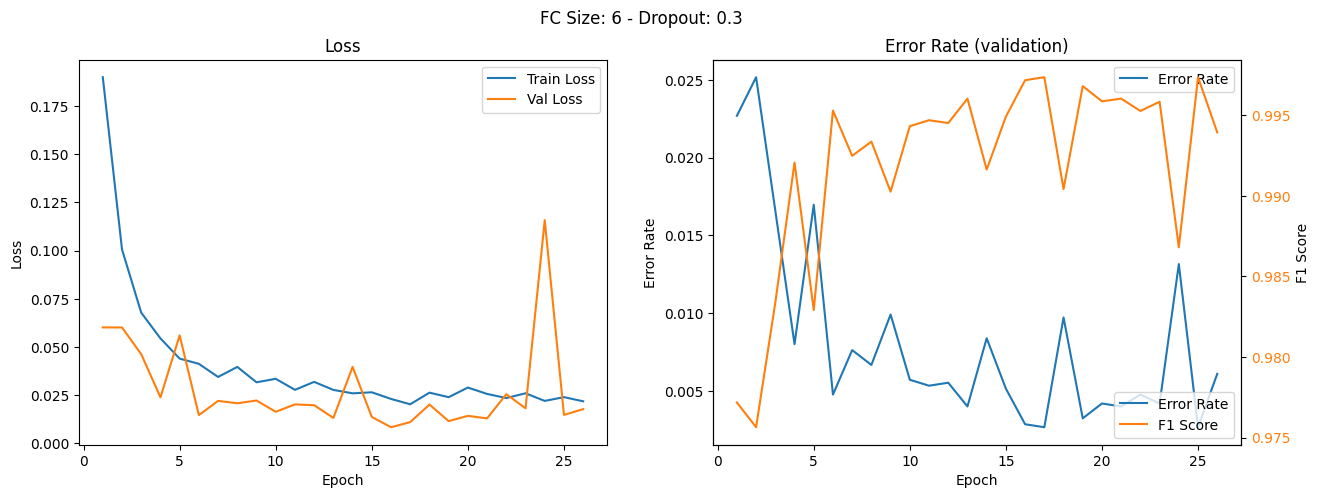

>>>>>>>>     FC Size: 6 - Dropout: 0.5     <<<<<<<<


Epoch 1/100	 Train Loss: 0.3607 - Val Loss: 0.0927 - Error Rate: 0.0227 - F1 Score: 0.9773 - (FPR: 0.0120 - FNR: 0.0332)


Epoch 2/100	 Train Loss: 0.2765 - Val Loss: 0.0665 - Error Rate: 0.0173 - F1 Score: 0.9829 - (FPR: 0.0203 - FNR: 0.0143)


Epoch 3/100	 Train Loss: 0.2171 - Val Loss: 0.0565 - Error Rate: 0.0231 - F1 Score: 0.9767 - (FPR: 0.0020 - FNR: 0.0428)


Epoch 4/100	 Train Loss: 0.2012 - Val Loss: 0.0504 - Error Rate: 0.0181 - F1 Score: 0.9818 - (FPR: 0.0012 - FNR: 0.0343)


Epoch 5/100	 Train Loss: 0.1828 - Val Loss: 0.0322 - Error Rate: 0.0088 - F1 Score: 0.9913 - (FPR: 0.0087 - FNR: 0.0089)


Epoch 6/100	 Train Loss: 0.1302 - Val Loss: 0.0212 - Error Rate: 0.0065 - F1 Score: 0.9936 - (FPR: 0.0072 - FNR: 0.0058)


Epoch 7/100	 Train Loss: 0.1027 - Val Loss: 0.0368 - Error Rate: 0.0109 - F1 Score: 0.9892 - (FPR: 0.0050 - FNR: 0.0167)


Epoch 8/100	 Train Loss: 0.1051 - Val Loss: 0.0291 - Error Rate: 0.0107 - F1 Score: 0.9893 - (FPR: 0.0008 - FNR: 0.0204)


Epoch 9/100	 Train Loss: 0.0954 - Val Loss: 0.0154 - Error Rate: 0.0050 - F1 Score: 0.9951 - (FPR: 0.0060 - FNR: 0.0039)


Epoch 10/100	 Train Loss: 0.0963 - Val Loss: 0.0123 - Error Rate: 0.0036 - F1 Score: 0.9964 - (FPR: 0.0034 - FNR: 0.0038)


Epoch 11/100	 Train Loss: 0.0965 - Val Loss: 0.0186 - Error Rate: 0.0050 - F1 Score: 0.9951 - (FPR: 0.0064 - FNR: 0.0035)


Epoch 12/100	 Train Loss: 0.0865 - Val Loss: 0.0153 - Error Rate: 0.0055 - F1 Score: 0.9945 - (FPR: 0.0004 - FNR: 0.0107)


Epoch 13/100	 Train Loss: 0.0893 - Val Loss: 0.0149 - Error Rate: 0.0050 - F1 Score: 0.9951 - (FPR: 0.0030 - FNR: 0.0069)


Epoch 14/100	 Train Loss: 0.0865 - Val Loss: 0.0184 - Error Rate: 0.0069 - F1 Score: 0.9932 - (FPR: 0.0015 - FNR: 0.0122)


Epoch 15/100	 Train Loss: 0.0848 - Val Loss: 0.0074 - Error Rate: 0.0017 - F1 Score: 0.9983 - (FPR: 0.0011 - FNR: 0.0023)


Epoch 16/100	 Train Loss: 0.0866 - Val Loss: 0.0117 - Error Rate: 0.0036 - F1 Score: 0.9964 - (FPR: 0.0011 - FNR: 0.0061)


Epoch 17/100	 Train Loss: 0.0923 - Val Loss: 0.0106 - Error Rate: 0.0034 - F1 Score: 0.9966 - (FPR: 0.0023 - FNR: 0.0046)


Epoch 18/100	 Train Loss: 0.0865 - Val Loss: 0.0100 - Error Rate: 0.0038 - F1 Score: 0.9962 - (FPR: 0.0019 - FNR: 0.0058)


Epoch 19/100	 Train Loss: 0.0845 - Val Loss: 0.0106 - Error Rate: 0.0042 - F1 Score: 0.9958 - (FPR: 0.0000 - FNR: 0.0084)


Epoch 20/100	 Train Loss: 0.0877 - Val Loss: 0.0077 - Error Rate: 0.0019 - F1 Score: 0.9981 - (FPR: 0.0015 - FNR: 0.0023)


Epoch 21/100	 Train Loss: 0.0833 - Val Loss: 0.0099 - Error Rate: 0.0027 - F1 Score: 0.9974 - (FPR: 0.0030 - FNR: 0.0023)


Epoch 22/100	 Train Loss: 0.0804 - Val Loss: 0.0346 - Error Rate: 0.0107 - F1 Score: 0.9893 - (FPR: 0.0004 - FNR: 0.0207)


Epoch 23/100	 Train Loss: 0.0831 - Val Loss: 0.0139 - Error Rate: 0.0053 - F1 Score: 0.9947 - (FPR: 0.0090 - FNR: 0.0016)


Epoch 24/100	 Train Loss: 0.0915 - Val Loss: 0.0097 - Error Rate: 0.0034 - F1 Score: 0.9966 - (FPR: 0.0030 - FNR: 0.0038)


Epoch 25/100	 Train Loss: 0.0811 - Val Loss: 0.0084 - Error Rate: 0.0021 - F1 Score: 0.9979 - (FPR: 0.0011 - FNR: 0.0031)


Epoch 26/100	 Train Loss: 0.0973 - Val Loss: 0.0192 - Error Rate: 0.0053 - F1 Score: 0.9947 - (FPR: 0.0000 - FNR: 0.0107)
Early stopping on epoch 26


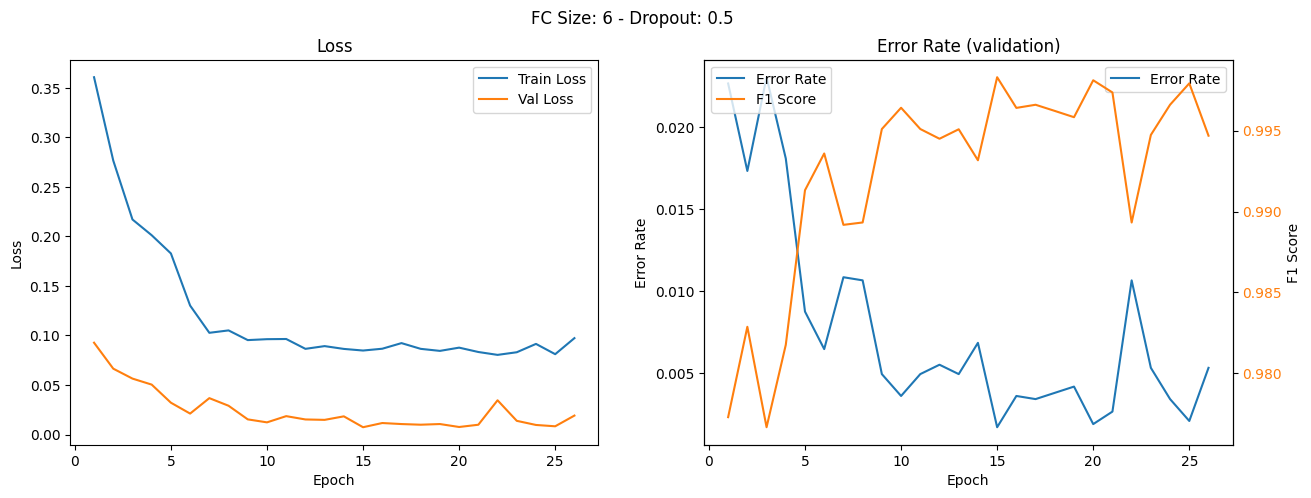

>>>>>>>>     FC Size: 12 - Dropout: 0.1     <<<<<<<<


Epoch 1/100	 Train Loss: 0.1493 - Val Loss: 0.0566 - Error Rate: 0.0202 - F1 Score: 0.9799 - (FPR: 0.0149 - FNR: 0.0255)


Epoch 2/100	 Train Loss: 0.0729 - Val Loss: 0.0646 - Error Rate: 0.0236 - F1 Score: 0.9761 - (FPR: 0.0031 - FNR: 0.0429)


Epoch 3/100	 Train Loss: 0.0546 - Val Loss: 0.0344 - Error Rate: 0.0120 - F1 Score: 0.9881 - (FPR: 0.0080 - FNR: 0.0160)


Epoch 4/100	 Train Loss: 0.0415 - Val Loss: 0.0407 - Error Rate: 0.0173 - F1 Score: 0.9831 - (FPR: 0.0301 - FNR: 0.0036)


Epoch 5/100	 Train Loss: 0.0347 - Val Loss: 0.0328 - Error Rate: 0.0105 - F1 Score: 0.9895 - (FPR: 0.0034 - FNR: 0.0175)


Epoch 6/100	 Train Loss: 0.0296 - Val Loss: 0.0203 - Error Rate: 0.0076 - F1 Score: 0.9924 - (FPR: 0.0038 - FNR: 0.0115)


Epoch 7/100	 Train Loss: 0.0182 - Val Loss: 0.0158 - Error Rate: 0.0057 - F1 Score: 0.9943 - (FPR: 0.0038 - FNR: 0.0077)


Epoch 8/100	 Train Loss: 0.0185 - Val Loss: 0.0434 - Error Rate: 0.0166 - F1 Score: 0.9838 - (FPR: 0.0297 - FNR: 0.0024)


Epoch 9/100	 Train Loss: 0.0157 - Val Loss: 0.0214 - Error Rate: 0.0080 - F1 Score: 0.9920 - (FPR: 0.0011 - FNR: 0.0148)


Epoch 10/100	 Train Loss: 0.0179 - Val Loss: 0.0199 - Error Rate: 0.0063 - F1 Score: 0.9938 - (FPR: 0.0030 - FNR: 0.0096)


Epoch 11/100	 Train Loss: 0.0098 - Val Loss: 0.0219 - Error Rate: 0.0078 - F1 Score: 0.9923 - (FPR: 0.0127 - FNR: 0.0027)


Epoch 12/100	 Train Loss: 0.0068 - Val Loss: 0.0103 - Error Rate: 0.0036 - F1 Score: 0.9964 - (FPR: 0.0030 - FNR: 0.0042)


Epoch 13/100	 Train Loss: 0.0103 - Val Loss: 0.0244 - Error Rate: 0.0080 - F1 Score: 0.9920 - (FPR: 0.0000 - FNR: 0.0159)


Epoch 14/100	 Train Loss: 0.0047 - Val Loss: 0.0232 - Error Rate: 0.0071 - F1 Score: 0.9931 - (FPR: 0.0120 - FNR: 0.0019)


Epoch 15/100	 Train Loss: 0.0108 - Val Loss: 0.0229 - Error Rate: 0.0071 - F1 Score: 0.9930 - (FPR: 0.0000 - FNR: 0.0140)


Epoch 16/100	 Train Loss: 0.0085 - Val Loss: 0.0128 - Error Rate: 0.0044 - F1 Score: 0.9956 - (FPR: 0.0015 - FNR: 0.0073)


Epoch 17/100	 Train Loss: 0.0038 - Val Loss: 0.0201 - Error Rate: 0.0048 - F1 Score: 0.9953 - (FPR: 0.0000 - FNR: 0.0095)


Epoch 18/100	 Train Loss: 0.0032 - Val Loss: 0.0119 - Error Rate: 0.0027 - F1 Score: 0.9974 - (FPR: 0.0019 - FNR: 0.0035)


Epoch 19/100	 Train Loss: 0.0090 - Val Loss: 0.0239 - Error Rate: 0.0082 - F1 Score: 0.9919 - (FPR: 0.0145 - FNR: 0.0016)


Epoch 20/100	 Train Loss: 0.0042 - Val Loss: 0.0294 - Error Rate: 0.0072 - F1 Score: 0.9928 - (FPR: 0.0098 - FNR: 0.0046)


Epoch 21/100	 Train Loss: 0.0095 - Val Loss: 0.0111 - Error Rate: 0.0048 - F1 Score: 0.9953 - (FPR: 0.0075 - FNR: 0.0019)


Epoch 22/100	 Train Loss: 0.0035 - Val Loss: 0.0129 - Error Rate: 0.0034 - F1 Score: 0.9966 - (FPR: 0.0000 - FNR: 0.0069)
Early stopping on epoch 22


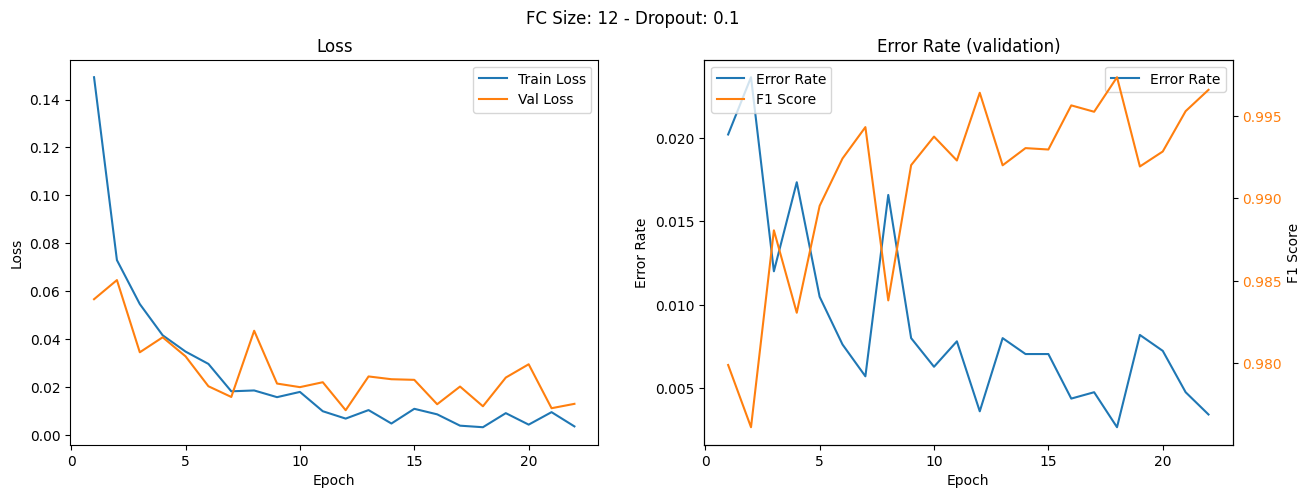

>>>>>>>>     FC Size: 12 - Dropout: 0.3     <<<<<<<<


Epoch 1/100	 Train Loss: 0.2387 - Val Loss: 0.0842 - Error Rate: 0.0254 - F1 Score: 0.9752 - (FPR: 0.0355 - FNR: 0.0146)


Epoch 2/100	 Train Loss: 0.1341 - Val Loss: 0.0897 - Error Rate: 0.0273 - F1 Score: 0.9736 - (FPR: 0.0486 - FNR: 0.0032)


Epoch 3/100	 Train Loss: 0.1109 - Val Loss: 0.0477 - Error Rate: 0.0172 - F1 Score: 0.9831 - (FPR: 0.0210 - FNR: 0.0132)


Epoch 4/100	 Train Loss: 0.0882 - Val Loss: 0.0395 - Error Rate: 0.0154 - F1 Score: 0.9845 - (FPR: 0.0016 - FNR: 0.0288)


Epoch 5/100	 Train Loss: 0.0734 - Val Loss: 0.0197 - Error Rate: 0.0055 - F1 Score: 0.9945 - (FPR: 0.0011 - FNR: 0.0099)


Epoch 6/100	 Train Loss: 0.0619 - Val Loss: 0.0204 - Error Rate: 0.0076 - F1 Score: 0.9924 - (FPR: 0.0015 - FNR: 0.0137)


Epoch 7/100	 Train Loss: 0.0481 - Val Loss: 0.0295 - Error Rate: 0.0093 - F1 Score: 0.9907 - (FPR: 0.0023 - FNR: 0.0163)


Epoch 8/100	 Train Loss: 0.0453 - Val Loss: 0.0128 - Error Rate: 0.0044 - F1 Score: 0.9956 - (FPR: 0.0019 - FNR: 0.0069)


Epoch 9/100	 Train Loss: 0.0366 - Val Loss: 0.0129 - Error Rate: 0.0040 - F1 Score: 0.9960 - (FPR: 0.0026 - FNR: 0.0054)


Epoch 10/100	 Train Loss: 0.0333 - Val Loss: 0.0160 - Error Rate: 0.0063 - F1 Score: 0.9937 - (FPR: 0.0008 - FNR: 0.0118)


Epoch 11/100	 Train Loss: 0.0288 - Val Loss: 0.0134 - Error Rate: 0.0044 - F1 Score: 0.9956 - (FPR: 0.0015 - FNR: 0.0073)


Epoch 12/100	 Train Loss: 0.0247 - Val Loss: 0.0127 - Error Rate: 0.0034 - F1 Score: 0.9966 - (FPR: 0.0011 - FNR: 0.0057)


Epoch 13/100	 Train Loss: 0.0270 - Val Loss: 0.0062 - Error Rate: 0.0027 - F1 Score: 0.9974 - (FPR: 0.0011 - FNR: 0.0042)


Epoch 14/100	 Train Loss: 0.0192 - Val Loss: 0.0842 - Error Rate: 0.0181 - F1 Score: 0.9824 - (FPR: 0.0329 - FNR: 0.0020)


Epoch 15/100	 Train Loss: 0.0218 - Val Loss: 0.0305 - Error Rate: 0.0107 - F1 Score: 0.9894 - (FPR: 0.0053 - FNR: 0.0160)


Epoch 16/100	 Train Loss: 0.0198 - Val Loss: 0.0112 - Error Rate: 0.0038 - F1 Score: 0.9962 - (FPR: 0.0008 - FNR: 0.0069)


Epoch 17/100	 Train Loss: 0.0138 - Val Loss: 0.0084 - Error Rate: 0.0023 - F1 Score: 0.9977 - (FPR: 0.0019 - FNR: 0.0027)


Epoch 18/100	 Train Loss: 0.0204 - Val Loss: 0.0201 - Error Rate: 0.0069 - F1 Score: 0.9932 - (FPR: 0.0127 - FNR: 0.0008)


Epoch 19/100	 Train Loss: 0.0130 - Val Loss: 0.0124 - Error Rate: 0.0034 - F1 Score: 0.9966 - (FPR: 0.0023 - FNR: 0.0046)


Epoch 20/100	 Train Loss: 0.0161 - Val Loss: 0.0163 - Error Rate: 0.0053 - F1 Score: 0.9947 - (FPR: 0.0000 - FNR: 0.0107)


Epoch 21/100	 Train Loss: 0.0161 - Val Loss: 0.0081 - Error Rate: 0.0023 - F1 Score: 0.9977 - (FPR: 0.0000 - FNR: 0.0046)


Epoch 22/100	 Train Loss: 0.0150 - Val Loss: 0.0210 - Error Rate: 0.0055 - F1 Score: 0.9945 - (FPR: 0.0008 - FNR: 0.0103)


Epoch 23/100	 Train Loss: 0.0112 - Val Loss: 0.0097 - Error Rate: 0.0027 - F1 Score: 0.9974 - (FPR: 0.0049 - FNR: 0.0004)
Early stopping on epoch 23


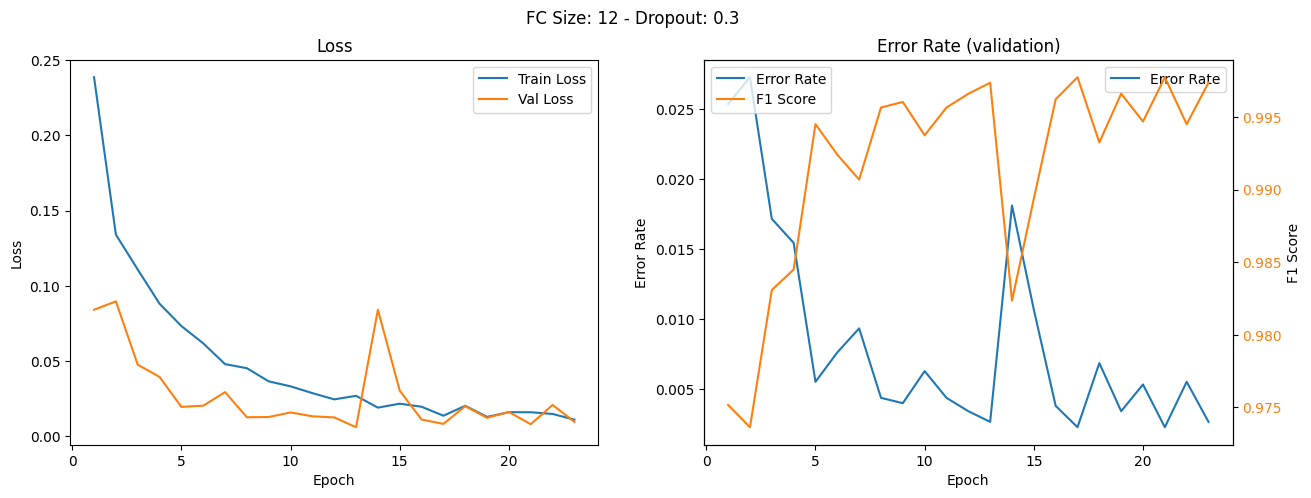

>>>>>>>>     FC Size: 12 - Dropout: 0.5     <<<<<<<<


Epoch 1/100	 Train Loss: 0.1808 - Val Loss: 0.0827 - Error Rate: 0.0337 - F1 Score: 0.9656 - (FPR: 0.0056 - FNR: 0.0594)


Epoch 2/100	 Train Loss: 0.1112 - Val Loss: 0.0485 - Error Rate: 0.0177 - F1 Score: 0.9824 - (FPR: 0.0170 - FNR: 0.0185)


Epoch 3/100	 Train Loss: 0.0954 - Val Loss: 0.0375 - Error Rate: 0.0145 - F1 Score: 0.9858 - (FPR: 0.0230 - FNR: 0.0055)


Epoch 4/100	 Train Loss: 0.0744 - Val Loss: 0.0370 - Error Rate: 0.0112 - F1 Score: 0.9888 - (FPR: 0.0015 - FNR: 0.0208)


Epoch 5/100	 Train Loss: 0.0676 - Val Loss: 0.0240 - Error Rate: 0.0088 - F1 Score: 0.9913 - (FPR: 0.0049 - FNR: 0.0126)


Epoch 6/100	 Train Loss: 0.0510 - Val Loss: 0.0149 - Error Rate: 0.0055 - F1 Score: 0.9945 - (FPR: 0.0019 - FNR: 0.0092)


Epoch 7/100	 Train Loss: 0.0516 - Val Loss: 0.0197 - Error Rate: 0.0088 - F1 Score: 0.9913 - (FPR: 0.0120 - FNR: 0.0054)


Epoch 8/100	 Train Loss: 0.0407 - Val Loss: 0.0250 - Error Rate: 0.0093 - F1 Score: 0.9908 - (FPR: 0.0131 - FNR: 0.0054)


Epoch 9/100	 Train Loss: 0.0382 - Val Loss: 0.0178 - Error Rate: 0.0072 - F1 Score: 0.9928 - (FPR: 0.0094 - FNR: 0.0050)


Epoch 10/100	 Train Loss: 0.0284 - Val Loss: 0.0180 - Error Rate: 0.0072 - F1 Score: 0.9929 - (FPR: 0.0112 - FNR: 0.0031)


Epoch 11/100	 Train Loss: 0.0305 - Val Loss: 0.0180 - Error Rate: 0.0063 - F1 Score: 0.9938 - (FPR: 0.0060 - FNR: 0.0065)


Epoch 12/100	 Train Loss: 0.0226 - Val Loss: 0.0411 - Error Rate: 0.0091 - F1 Score: 0.9909 - (FPR: 0.0057 - FNR: 0.0126)


Epoch 13/100	 Train Loss: 0.0244 - Val Loss: 0.0452 - Error Rate: 0.0097 - F1 Score: 0.9903 - (FPR: 0.0000 - FNR: 0.0193)


Epoch 14/100	 Train Loss: 0.0181 - Val Loss: 0.0359 - Error Rate: 0.0055 - F1 Score: 0.9945 - (FPR: 0.0011 - FNR: 0.0099)


Epoch 15/100	 Train Loss: 0.0239 - Val Loss: 0.0120 - Error Rate: 0.0042 - F1 Score: 0.9958 - (FPR: 0.0045 - FNR: 0.0039)


Epoch 16/100	 Train Loss: 0.0170 - Val Loss: 0.0111 - Error Rate: 0.0034 - F1 Score: 0.9966 - (FPR: 0.0045 - FNR: 0.0023)


Epoch 17/100	 Train Loss: 0.0194 - Val Loss: 0.0304 - Error Rate: 0.0091 - F1 Score: 0.9909 - (FPR: 0.0098 - FNR: 0.0085)


Epoch 18/100	 Train Loss: 0.0148 - Val Loss: 0.0194 - Error Rate: 0.0044 - F1 Score: 0.9956 - (FPR: 0.0023 - FNR: 0.0065)


Epoch 19/100	 Train Loss: 0.0219 - Val Loss: 0.0288 - Error Rate: 0.0057 - F1 Score: 0.9943 - (FPR: 0.0027 - FNR: 0.0088)


Epoch 20/100	 Train Loss: 0.0131 - Val Loss: 0.0135 - Error Rate: 0.0042 - F1 Score: 0.9958 - (FPR: 0.0045 - FNR: 0.0039)


Epoch 21/100	 Train Loss: 0.0148 - Val Loss: 0.0107 - Error Rate: 0.0038 - F1 Score: 0.9962 - (FPR: 0.0034 - FNR: 0.0042)


Epoch 22/100	 Train Loss: 0.0166 - Val Loss: 0.0184 - Error Rate: 0.0030 - F1 Score: 0.9970 - (FPR: 0.0008 - FNR: 0.0054)


Epoch 23/100	 Train Loss: 0.0199 - Val Loss: 0.0168 - Error Rate: 0.0036 - F1 Score: 0.9964 - (FPR: 0.0008 - FNR: 0.0065)


Epoch 24/100	 Train Loss: 0.0098 - Val Loss: 0.0353 - Error Rate: 0.0053 - F1 Score: 0.9947 - (FPR: 0.0008 - FNR: 0.0099)


Epoch 25/100	 Train Loss: 0.0186 - Val Loss: 0.0136 - Error Rate: 0.0046 - F1 Score: 0.9955 - (FPR: 0.0049 - FNR: 0.0042)


Epoch 26/100	 Train Loss: 0.0137 - Val Loss: 0.0293 - Error Rate: 0.0063 - F1 Score: 0.9937 - (FPR: 0.0019 - FNR: 0.0107)


Epoch 27/100	 Train Loss: 0.0179 - Val Loss: 0.0158 - Error Rate: 0.0061 - F1 Score: 0.9940 - (FPR: 0.0108 - FNR: 0.0012)


Epoch 28/100	 Train Loss: 0.0108 - Val Loss: 0.0109 - Error Rate: 0.0038 - F1 Score: 0.9962 - (FPR: 0.0045 - FNR: 0.0031)


Epoch 29/100	 Train Loss: 0.0159 - Val Loss: 0.0273 - Error Rate: 0.0042 - F1 Score: 0.9958 - (FPR: 0.0011 - FNR: 0.0073)


Epoch 30/100	 Train Loss: 0.0137 - Val Loss: 0.0176 - Error Rate: 0.0067 - F1 Score: 0.9934 - (FPR: 0.0109 - FNR: 0.0023)


Epoch 31/100	 Train Loss: 0.0128 - Val Loss: 0.0294 - Error Rate: 0.0048 - F1 Score: 0.9953 - (FPR: 0.0011 - FNR: 0.0084)


Epoch 32/100	 Train Loss: 0.0153 - Val Loss: 0.0256 - Error Rate: 0.0069 - F1 Score: 0.9932 - (FPR: 0.0072 - FNR: 0.0066)
Early stopping on epoch 32


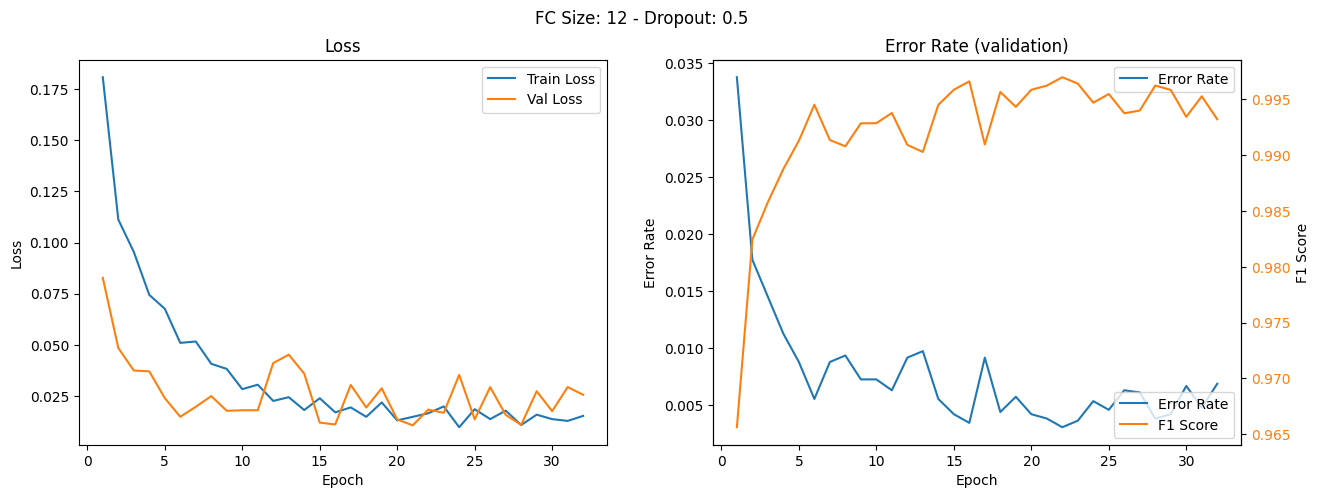

>>>>>>>>     FC Size: 24 - Dropout: 0.1     <<<<<<<<


Epoch 1/100	 Train Loss: 0.1430 - Val Loss: 0.0694 - Error Rate: 0.0273 - F1 Score: 0.9728 - (FPR: 0.0214 - FNR: 0.0331)


Epoch 2/100	 Train Loss: 0.0701 - Val Loss: 0.0425 - Error Rate: 0.0145 - F1 Score: 0.9856 - (FPR: 0.0084 - FNR: 0.0205)


Epoch 3/100	 Train Loss: 0.0505 - Val Loss: 0.0578 - Error Rate: 0.0210 - F1 Score: 0.9790 - (FPR: 0.0108 - FNR: 0.0309)


Epoch 4/100	 Train Loss: 0.0410 - Val Loss: 0.0230 - Error Rate: 0.0088 - F1 Score: 0.9913 - (FPR: 0.0113 - FNR: 0.0062)


Epoch 5/100	 Train Loss: 0.0281 - Val Loss: 0.0518 - Error Rate: 0.0179 - F1 Score: 0.9820 - (FPR: 0.0008 - FNR: 0.0342)


Epoch 6/100	 Train Loss: 0.0249 - Val Loss: 0.0185 - Error Rate: 0.0055 - F1 Score: 0.9945 - (FPR: 0.0057 - FNR: 0.0054)


Epoch 7/100	 Train Loss: 0.0182 - Val Loss: 0.0086 - Error Rate: 0.0025 - F1 Score: 0.9975 - (FPR: 0.0015 - FNR: 0.0035)


Epoch 8/100	 Train Loss: 0.0117 - Val Loss: 0.0233 - Error Rate: 0.0084 - F1 Score: 0.9916 - (FPR: 0.0008 - FNR: 0.0159)


Epoch 9/100	 Train Loss: 0.0100 - Val Loss: 0.0083 - Error Rate: 0.0027 - F1 Score: 0.9974 - (FPR: 0.0023 - FNR: 0.0031)


Epoch 10/100	 Train Loss: 0.0104 - Val Loss: 0.0272 - Error Rate: 0.0095 - F1 Score: 0.9906 - (FPR: 0.0167 - FNR: 0.0020)


Epoch 11/100	 Train Loss: 0.0124 - Val Loss: 0.0117 - Error Rate: 0.0030 - F1 Score: 0.9970 - (FPR: 0.0019 - FNR: 0.0042)


Epoch 12/100	 Train Loss: 0.0030 - Val Loss: 0.0173 - Error Rate: 0.0040 - F1 Score: 0.9960 - (FPR: 0.0015 - FNR: 0.0065)


Epoch 13/100	 Train Loss: 0.0113 - Val Loss: 0.0580 - Error Rate: 0.0200 - F1 Score: 0.9806 - (FPR: 0.0381 - FNR: 0.0000)


Epoch 14/100	 Train Loss: 0.0087 - Val Loss: 0.0122 - Error Rate: 0.0032 - F1 Score: 0.9968 - (FPR: 0.0008 - FNR: 0.0057)


Epoch 15/100	 Train Loss: 0.0060 - Val Loss: 0.0140 - Error Rate: 0.0042 - F1 Score: 0.9958 - (FPR: 0.0034 - FNR: 0.0050)


Epoch 16/100	 Train Loss: 0.0076 - Val Loss: 0.0147 - Error Rate: 0.0040 - F1 Score: 0.9960 - (FPR: 0.0000 - FNR: 0.0080)


Epoch 17/100	 Train Loss: 0.0034 - Val Loss: 0.0253 - Error Rate: 0.0069 - F1 Score: 0.9932 - (FPR: 0.0011 - FNR: 0.0126)


Epoch 18/100	 Train Loss: 0.0049 - Val Loss: 0.0060 - Error Rate: 0.0029 - F1 Score: 0.9972 - (FPR: 0.0038 - FNR: 0.0019)


Epoch 19/100	 Train Loss: 0.0041 - Val Loss: 0.0090 - Error Rate: 0.0030 - F1 Score: 0.9970 - (FPR: 0.0034 - FNR: 0.0027)


Epoch 20/100	 Train Loss: 0.0050 - Val Loss: 0.0137 - Error Rate: 0.0042 - F1 Score: 0.9958 - (FPR: 0.0008 - FNR: 0.0076)


Epoch 21/100	 Train Loss: 0.0044 - Val Loss: 0.0144 - Error Rate: 0.0051 - F1 Score: 0.9949 - (FPR: 0.0023 - FNR: 0.0080)


Epoch 22/100	 Train Loss: 0.0044 - Val Loss: 0.0708 - Error Rate: 0.0143 - F1 Score: 0.9856 - (FPR: 0.0000 - FNR: 0.0281)


Epoch 23/100	 Train Loss: 0.0044 - Val Loss: 0.0057 - Error Rate: 0.0015 - F1 Score: 0.9985 - (FPR: 0.0008 - FNR: 0.0023)


Epoch 24/100	 Train Loss: 0.0036 - Val Loss: 0.0451 - Error Rate: 0.0091 - F1 Score: 0.9909 - (FPR: 0.0004 - FNR: 0.0178)


Epoch 25/100	 Train Loss: 0.0027 - Val Loss: 0.0143 - Error Rate: 0.0030 - F1 Score: 0.9970 - (FPR: 0.0008 - FNR: 0.0054)


Epoch 26/100	 Train Loss: 0.0047 - Val Loss: 0.0108 - Error Rate: 0.0038 - F1 Score: 0.9962 - (FPR: 0.0008 - FNR: 0.0069)


Epoch 27/100	 Train Loss: 0.0006 - Val Loss: 0.0138 - Error Rate: 0.0030 - F1 Score: 0.9970 - (FPR: 0.0000 - FNR: 0.0061)


Epoch 28/100	 Train Loss: 0.0041 - Val Loss: 0.0078 - Error Rate: 0.0015 - F1 Score: 0.9985 - (FPR: 0.0004 - FNR: 0.0027)


Epoch 29/100	 Train Loss: 0.0020 - Val Loss: 0.0071 - Error Rate: 0.0023 - F1 Score: 0.9977 - (FPR: 0.0026 - FNR: 0.0019)


Epoch 30/100	 Train Loss: 0.0050 - Val Loss: 0.0174 - Error Rate: 0.0051 - F1 Score: 0.9949 - (FPR: 0.0090 - FNR: 0.0012)


Epoch 31/100	 Train Loss: 0.0071 - Val Loss: 0.0071 - Error Rate: 0.0017 - F1 Score: 0.9983 - (FPR: 0.0019 - FNR: 0.0015)


Epoch 32/100	 Train Loss: 0.0004 - Val Loss: 0.0100 - Error Rate: 0.0027 - F1 Score: 0.9974 - (FPR: 0.0011 - FNR: 0.0042)


Epoch 33/100	 Train Loss: 0.0049 - Val Loss: 0.0183 - Error Rate: 0.0042 - F1 Score: 0.9958 - (FPR: 0.0011 - FNR: 0.0073)
Early stopping on epoch 33


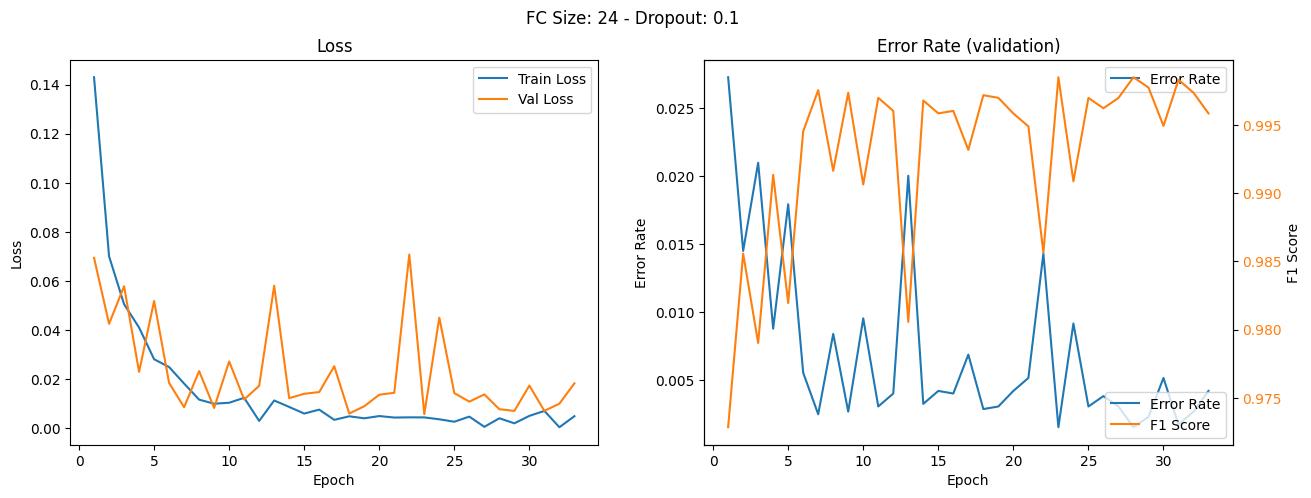

>>>>>>>>     FC Size: 24 - Dropout: 0.3     <<<<<<<<


Epoch 1/100	 Train Loss: 0.1545 - Val Loss: 0.0829 - Error Rate: 0.0326 - F1 Score: 0.9686 - (FPR: 0.0569 - FNR: 0.0049)


Epoch 2/100	 Train Loss: 0.0671 - Val Loss: 0.0470 - Error Rate: 0.0191 - F1 Score: 0.9811 - (FPR: 0.0174 - FNR: 0.0207)


Epoch 3/100	 Train Loss: 0.0502 - Val Loss: 0.0279 - Error Rate: 0.0105 - F1 Score: 0.9896 - (FPR: 0.0095 - FNR: 0.0115)


Epoch 4/100	 Train Loss: 0.0392 - Val Loss: 0.0251 - Error Rate: 0.0093 - F1 Score: 0.9907 - (FPR: 0.0034 - FNR: 0.0152)


Epoch 5/100	 Train Loss: 0.0292 - Val Loss: 0.0215 - Error Rate: 0.0076 - F1 Score: 0.9925 - (FPR: 0.0079 - FNR: 0.0073)


Epoch 6/100	 Train Loss: 0.0199 - Val Loss: 0.0307 - Error Rate: 0.0122 - F1 Score: 0.9878 - (FPR: 0.0008 - FNR: 0.0233)


Epoch 7/100	 Train Loss: 0.0188 - Val Loss: 0.0155 - Error Rate: 0.0046 - F1 Score: 0.9955 - (FPR: 0.0015 - FNR: 0.0077)


Epoch 8/100	 Train Loss: 0.0163 - Val Loss: 0.0185 - Error Rate: 0.0061 - F1 Score: 0.9939 - (FPR: 0.0019 - FNR: 0.0103)


Epoch 9/100	 Train Loss: 0.0131 - Val Loss: 0.0135 - Error Rate: 0.0046 - F1 Score: 0.9955 - (FPR: 0.0015 - FNR: 0.0077)


Epoch 10/100	 Train Loss: 0.0074 - Val Loss: 0.0139 - Error Rate: 0.0051 - F1 Score: 0.9949 - (FPR: 0.0049 - FNR: 0.0054)


Epoch 11/100	 Train Loss: 0.0110 - Val Loss: 0.0218 - Error Rate: 0.0059 - F1 Score: 0.9941 - (FPR: 0.0008 - FNR: 0.0111)


Epoch 12/100	 Train Loss: 0.0070 - Val Loss: 0.0142 - Error Rate: 0.0051 - F1 Score: 0.9949 - (FPR: 0.0011 - FNR: 0.0092)


Epoch 13/100	 Train Loss: 0.0086 - Val Loss: 0.0097 - Error Rate: 0.0040 - F1 Score: 0.9960 - (FPR: 0.0030 - FNR: 0.0050)


Epoch 14/100	 Train Loss: 0.0077 - Val Loss: 0.0180 - Error Rate: 0.0051 - F1 Score: 0.9949 - (FPR: 0.0000 - FNR: 0.0103)


Epoch 15/100	 Train Loss: 0.0076 - Val Loss: 0.0147 - Error Rate: 0.0044 - F1 Score: 0.9957 - (FPR: 0.0056 - FNR: 0.0031)


Epoch 16/100	 Train Loss: 0.0051 - Val Loss: 0.0338 - Error Rate: 0.0065 - F1 Score: 0.9935 - (FPR: 0.0004 - FNR: 0.0126)


Epoch 17/100	 Train Loss: 0.0064 - Val Loss: 0.0125 - Error Rate: 0.0040 - F1 Score: 0.9960 - (FPR: 0.0023 - FNR: 0.0058)


Epoch 18/100	 Train Loss: 0.0047 - Val Loss: 0.0265 - Error Rate: 0.0061 - F1 Score: 0.9940 - (FPR: 0.0094 - FNR: 0.0027)


Epoch 19/100	 Train Loss: 0.0026 - Val Loss: 0.0098 - Error Rate: 0.0027 - F1 Score: 0.9974 - (FPR: 0.0030 - FNR: 0.0023)


Epoch 20/100	 Train Loss: 0.0124 - Val Loss: 0.0213 - Error Rate: 0.0063 - F1 Score: 0.9937 - (FPR: 0.0004 - FNR: 0.0122)


Epoch 21/100	 Train Loss: 0.0055 - Val Loss: 0.0112 - Error Rate: 0.0036 - F1 Score: 0.9964 - (FPR: 0.0034 - FNR: 0.0038)


Epoch 22/100	 Train Loss: 0.0052 - Val Loss: 0.0264 - Error Rate: 0.0051 - F1 Score: 0.9949 - (FPR: 0.0004 - FNR: 0.0099)


Epoch 23/100	 Train Loss: 0.0007 - Val Loss: 0.0166 - Error Rate: 0.0030 - F1 Score: 0.9970 - (FPR: 0.0000 - FNR: 0.0061)


Epoch 24/100	 Train Loss: 0.0083 - Val Loss: 0.0159 - Error Rate: 0.0040 - F1 Score: 0.9960 - (FPR: 0.0004 - FNR: 0.0076)
Early stopping on epoch 24


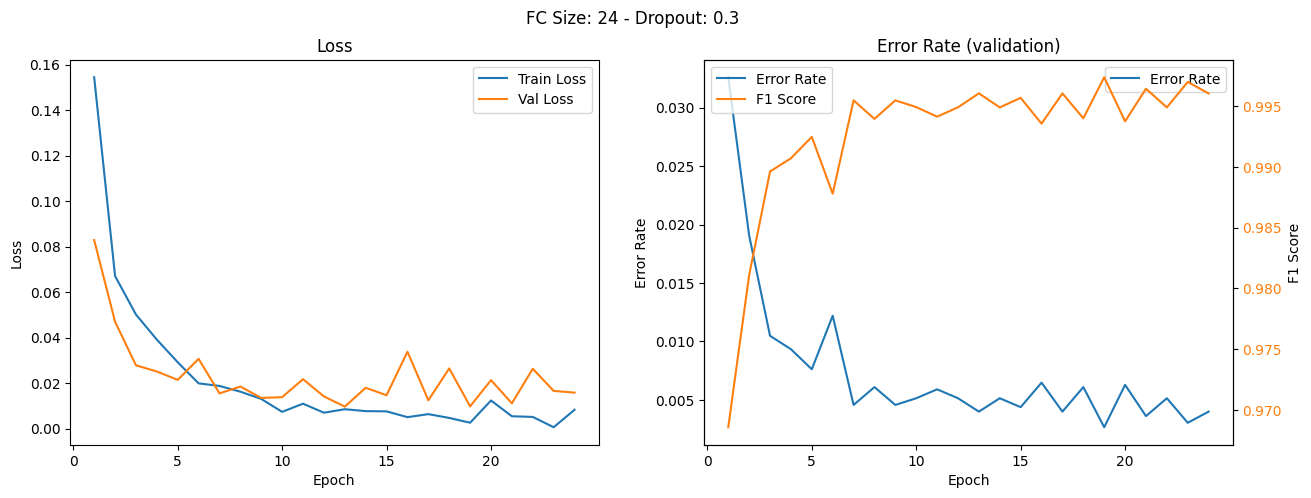

>>>>>>>>     FC Size: 24 - Dropout: 0.5     <<<<<<<<


Epoch 1/100	 Train Loss: 0.1657 - Val Loss: 0.0789 - Error Rate: 0.0288 - F1 Score: 0.9711 - (FPR: 0.0140 - FNR: 0.0430)


Epoch 2/100	 Train Loss: 0.0705 - Val Loss: 0.0497 - Error Rate: 0.0200 - F1 Score: 0.9804 - (FPR: 0.0303 - FNR: 0.0091)


Epoch 3/100	 Train Loss: 0.0567 - Val Loss: 0.0374 - Error Rate: 0.0141 - F1 Score: 0.9860 - (FPR: 0.0151 - FNR: 0.0131)


Epoch 4/100	 Train Loss: 0.0450 - Val Loss: 0.0397 - Error Rate: 0.0149 - F1 Score: 0.9851 - (FPR: 0.0031 - FNR: 0.0263)


Epoch 5/100	 Train Loss: 0.0410 - Val Loss: 0.0282 - Error Rate: 0.0097 - F1 Score: 0.9904 - (FPR: 0.0109 - FNR: 0.0085)


Epoch 6/100	 Train Loss: 0.0274 - Val Loss: 0.0194 - Error Rate: 0.0048 - F1 Score: 0.9953 - (FPR: 0.0071 - FNR: 0.0023)


Epoch 7/100	 Train Loss: 0.0240 - Val Loss: 0.0309 - Error Rate: 0.0099 - F1 Score: 0.9901 - (FPR: 0.0019 - FNR: 0.0178)


Epoch 8/100	 Train Loss: 0.0230 - Val Loss: 0.0315 - Error Rate: 0.0111 - F1 Score: 0.9889 - (FPR: 0.0000 - FNR: 0.0218)


Epoch 9/100	 Train Loss: 0.0168 - Val Loss: 0.0252 - Error Rate: 0.0093 - F1 Score: 0.9907 - (FPR: 0.0000 - FNR: 0.0185)


Epoch 10/100	 Train Loss: 0.0172 - Val Loss: 0.0112 - Error Rate: 0.0048 - F1 Score: 0.9953 - (FPR: 0.0019 - FNR: 0.0077)


Epoch 11/100	 Train Loss: 0.0135 - Val Loss: 0.0407 - Error Rate: 0.0133 - F1 Score: 0.9866 - (FPR: 0.0000 - FNR: 0.0262)


Epoch 12/100	 Train Loss: 0.0123 - Val Loss: 0.0138 - Error Rate: 0.0065 - F1 Score: 0.9936 - (FPR: 0.0034 - FNR: 0.0096)


Epoch 13/100	 Train Loss: 0.0099 - Val Loss: 0.0154 - Error Rate: 0.0055 - F1 Score: 0.9945 - (FPR: 0.0019 - FNR: 0.0092)


Epoch 14/100	 Train Loss: 0.0099 - Val Loss: 0.0194 - Error Rate: 0.0053 - F1 Score: 0.9947 - (FPR: 0.0008 - FNR: 0.0099)


Epoch 15/100	 Train Loss: 0.0146 - Val Loss: 0.0089 - Error Rate: 0.0032 - F1 Score: 0.9968 - (FPR: 0.0011 - FNR: 0.0054)


Epoch 16/100	 Train Loss: 0.0064 - Val Loss: 0.0107 - Error Rate: 0.0040 - F1 Score: 0.9960 - (FPR: 0.0011 - FNR: 0.0069)


Epoch 17/100	 Train Loss: 0.0110 - Val Loss: 0.0102 - Error Rate: 0.0025 - F1 Score: 0.9975 - (FPR: 0.0019 - FNR: 0.0031)


Epoch 18/100	 Train Loss: 0.0057 - Val Loss: 0.0120 - Error Rate: 0.0046 - F1 Score: 0.9955 - (FPR: 0.0056 - FNR: 0.0035)


Epoch 19/100	 Train Loss: 0.0103 - Val Loss: 0.0105 - Error Rate: 0.0048 - F1 Score: 0.9953 - (FPR: 0.0023 - FNR: 0.0073)


Epoch 20/100	 Train Loss: 0.0042 - Val Loss: 0.0071 - Error Rate: 0.0019 - F1 Score: 0.9981 - (FPR: 0.0004 - FNR: 0.0035)


Epoch 21/100	 Train Loss: 0.0080 - Val Loss: 0.0097 - Error Rate: 0.0029 - F1 Score: 0.9972 - (FPR: 0.0015 - FNR: 0.0042)


Epoch 22/100	 Train Loss: 0.0051 - Val Loss: 0.0106 - Error Rate: 0.0030 - F1 Score: 0.9970 - (FPR: 0.0019 - FNR: 0.0042)


Epoch 23/100	 Train Loss: 0.0060 - Val Loss: 0.0088 - Error Rate: 0.0019 - F1 Score: 0.9981 - (FPR: 0.0015 - FNR: 0.0023)


Epoch 24/100	 Train Loss: 0.0069 - Val Loss: 0.0158 - Error Rate: 0.0040 - F1 Score: 0.9960 - (FPR: 0.0023 - FNR: 0.0058)


Epoch 25/100	 Train Loss: 0.0072 - Val Loss: 0.0150 - Error Rate: 0.0027 - F1 Score: 0.9974 - (FPR: 0.0004 - FNR: 0.0050)


Epoch 26/100	 Train Loss: 0.0062 - Val Loss: 0.0084 - Error Rate: 0.0023 - F1 Score: 0.9977 - (FPR: 0.0015 - FNR: 0.0031)


Epoch 27/100	 Train Loss: 0.0084 - Val Loss: 0.0130 - Error Rate: 0.0050 - F1 Score: 0.9951 - (FPR: 0.0086 - FNR: 0.0012)


Epoch 28/100	 Train Loss: 0.0040 - Val Loss: 0.0267 - Error Rate: 0.0044 - F1 Score: 0.9956 - (FPR: 0.0008 - FNR: 0.0080)


Epoch 29/100	 Train Loss: 0.0017 - Val Loss: 0.0179 - Error Rate: 0.0023 - F1 Score: 0.9977 - (FPR: 0.0008 - FNR: 0.0038)


Epoch 30/100	 Train Loss: 0.0072 - Val Loss: 0.0095 - Error Rate: 0.0032 - F1 Score: 0.9968 - (FPR: 0.0000 - FNR: 0.0065)
Early stopping on epoch 30


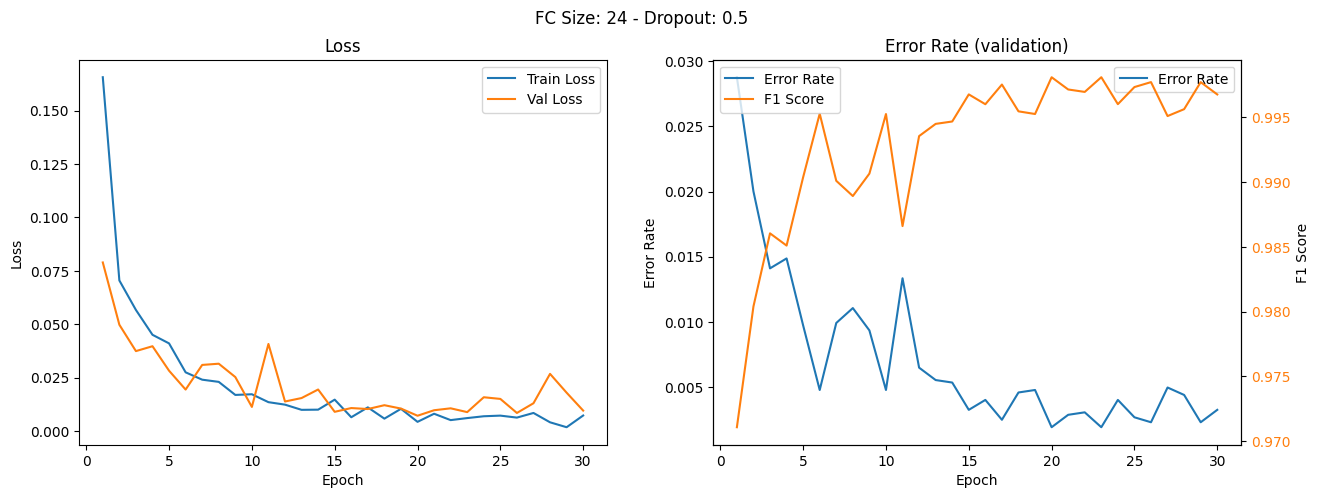

In [38]:
fc_sizes = [6, 12, 24]
dropouts = [0.1, 0.3, 0.5]
%matplotlib inline

best_models = []

for fc_size in fc_sizes:
    for dropout in dropouts:
        
        print(f'>>>>>>>>     FC Size: {fc_size} - Dropout: {dropout}     <<<<<<<<')
        # Create the model
        model = CustomConvNet(fc_size=fc_size, dropout=dropout).to(device)

        # Define the loss function and optimizer
        criterion = nn.BCEWithLogitsLoss().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

        # Create the dataloaders
        train_dataloader = torch.utils.data.DataLoader(train_data, BATCH_SIZE, shuffle=True)
        val_dataloader = torch.utils.data.DataLoader(val_data, BATCH_SIZE, shuffle=False)

        train_losses = []
        val_losses = []
        err_rates = []
        f1_scores = []
        early_stopper = EarlyStopper(patience=10, min_delta=5e-4)
        best_epoch = None

        for epoch in range(EPOCHS):
            train_loss = train_model(train_dataloader, model, criterion, optimizer, checkpoint=False, desc=f'TrainingEpoch{(epoch + 1):02d}')
            val_loss, errors, confusion_matrix = evaluate(val_dataloader, model, criterion, desc=f'ValidationEpoch{(epoch + 1):02d}')
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            error_rate = (sum(errors) / len(val_data)).item()
            err_rates.append(error_rate)
            f1 = f1_score(confusion_matrix)
            f1_scores.append(f1)
            fpr = confusion_matrix[0][1] / (confusion_matrix[0][0] + confusion_matrix[0][1])
            fnr = confusion_matrix[1][0] / (confusion_matrix[1][0] + confusion_matrix[1][1])
            print(f'Epoch {epoch + 1}/{EPOCHS}\t Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Error Rate: {error_rate:.4f} - F1 Score: {f1:.4f} - (FPR: {fpr:.4f} - FNR: {fnr:.4f})')
            if best_epoch is None or val_loss < val_losses[best_epoch]:
                best_epoch = epoch
                save_checkpoint(model, optimizer, val_loss, f'w_data_aug/fc_{fc_size}_dropout_{dropout}_lr_{LEARNING_RATE}', f'epoch{epoch+1}')

            if early_stopper.early_stop(val_loss):
                print(f'Early stopping on epoch {epoch + 1}')
                break
        
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        fig.suptitle(f'FC Size: {fc_size} - Dropout: {dropout}')
        
        ax[0].set_title('Loss')
        ax[1].set_title('Error Rate (validation)')
        
        epochs = [i+1 for i in range(len(train_losses))]
        ax[0].plot(epochs, train_losses, label='Train Loss', color='tab:blue')
        ax[0].plot(epochs, val_losses, label='Val Loss', color='tab:orange')
        ax[1].plot(epochs, err_rates, label='Error Rate', color='tab:blue')
        ax2 = ax[1].twinx()
        ax2.plot(epochs, f1_scores, color='tab:orange', label='F1 Score')
        
        epochs = [i for i in range(0, len(train_losses)+1, 5)]
        ax[0].set_xlabel('Epoch')
        ax[0].set_xticks(epochs)
        ax[0].set_ylabel('Loss')
        ax[0].legend()
        ax[1].set_xlabel('Epoch')
        ax[1].set_xticks(epochs)
        ax[1].set_ylabel('Error Rate')
        ax[1].legend()
        ax2.set_ylabel('F1 Score')
        ax2.tick_params(axis='y', labelcolor='tab:orange')
        # Add legend
        lines, labels = ax[1].get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='best')

        plt.show()
        fig_dir = os.path.join(FIGURES_DIR, f'w_data_aug')
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)
        fig_path = os.path.join(fig_dir, f'fc_{fc_size}_dropout_{dropout}_lr_{LEARNING_RATE}.png')
        
        fig.savefig(fig_path)

        best_models.append({
            'fc_size': fc_size,
            'dropout': dropout,
            'best_epoch': best_epoch,
            'train_loss': train_losses[best_epoch],
            'val_loss': val_losses[best_epoch],
            'error_rate': err_rates[best_epoch],
            'f1_score': f1_scores[best_epoch],
            'fig_path': fig_path,
        })

In [39]:
best_model = min(best_models, key=lambda x: x['val_loss'])

In [40]:
display(best_models)

[{'fc_size': 6,
  'dropout': 0.1,
  'best_epoch': 19,
  'train_loss': 0.007271580916602039,
  'val_loss': 0.007428567373046381,
  'error_rate': 0.00247807870618999,
  'f1_score': 0.9975429975429975,
  'fig_path': 'figures/w_data_aug/fc_6_dropout_0.1_lr_0.001.png'},
 {'fc_size': 6,
  'dropout': 0.3,
  'best_epoch': 15,
  'train_loss': 0.022976240617968203,
  'val_loss': 0.0082806647110282,
  'error_rate': 0.0028593214228749275,
  'f1_score': 0.9971692772221173,
  'fig_path': 'figures/w_data_aug/fc_6_dropout_0.3_lr_0.001.png'},
 {'fc_size': 6,
  'dropout': 0.5,
  'best_epoch': 14,
  'train_loss': 0.08482664758336861,
  'val_loss': 0.007432735051421482,
  'error_rate': 0.0017155929235741496,
  'f1_score': 0.998300283286119,
  'fig_path': 'figures/w_data_aug/fc_6_dropout_0.5_lr_0.001.png'},
 {'fc_size': 12,
  'dropout': 0.1,
  'best_epoch': 11,
  'train_loss': 0.006758884906018396,
  'val_loss': 0.010257345080582316,
  'error_rate': 0.003621807089075446,
  'f1_score': 0.9964117091595845,
 

In [41]:
display(best_model)

{'fc_size': 24,
 'dropout': 0.1,
 'best_epoch': 22,
 'train_loss': 0.0044203007675149295,
 'val_loss': 0.005735476856920303,
 'error_rate': 0.001524971448816359,
 'f1_score': 0.9984888553078958,
 'fig_path': 'figures/w_data_aug/fc_24_dropout_0.1_lr_0.001.png'}

In [42]:
sort_best_models = sorted(best_models, key=lambda x: x['val_loss'])
display(sort_best_models)

[{'fc_size': 24,
  'dropout': 0.1,
  'best_epoch': 22,
  'train_loss': 0.0044203007675149295,
  'val_loss': 0.005735476856920303,
  'error_rate': 0.001524971448816359,
  'f1_score': 0.9984888553078958,
  'fig_path': 'figures/w_data_aug/fc_24_dropout_0.1_lr_0.001.png'},
 {'fc_size': 12,
  'dropout': 0.3,
  'best_epoch': 12,
  'train_loss': 0.027009998752508563,
  'val_loss': 0.0061509796292469575,
  'error_rate': 0.002668699948117137,
  'f1_score': 0.9973534971644611,
  'fig_path': 'figures/w_data_aug/fc_12_dropout_0.3_lr_0.001.png'},
 {'fc_size': 24,
  'dropout': 0.5,
  'best_epoch': 19,
  'train_loss': 0.004241332991767505,
  'val_loss': 0.007104582088910229,
  'error_rate': 0.0019062142819166183,
  'f1_score': 0.998109640831758,
  'fig_path': 'figures/w_data_aug/fc_24_dropout_0.5_lr_0.001.png'},
 {'fc_size': 6,
  'dropout': 0.1,
  'best_epoch': 19,
  'train_loss': 0.007271580916602039,
  'val_loss': 0.007428567373046381,
  'error_rate': 0.00247807870618999,
  'f1_score': 0.9975429975